# Ouroboros: Experiments

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import logging
import warnings

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn import linear_model as LR
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
BASE_PATH = os.path.dirname(os.path.abspath('__file__'))

SELF_LEARNER_MODULE_PATH = os.path.abspath(os.path.join(BASE_PATH, os.path.pardir))
SELF_LEARNER_LIB_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'selflearner')
os.chdir(SELF_LEARNER_LIB_PATH)
sys.path.insert(0, SELF_LEARNER_MODULE_PATH)

# Paths of dump
import pickle
CLASSES_CNT_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'classes_count.pkl')
EXP_OUROBOROS_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros.pkl')
EXP_PREVIOUS_PRES_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_previous_pres.pkl')
EXP_OUROBOROS_SAMPLING_DUMP_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'exp_ouroboros_sampling.pkl')

from selflearner.multi_day_experiment import MultiDayExperiment
from selflearner.problem_definition import ProblemDefinition, TrainingType
from selflearner.data_load.features_extraction_oulad import Hdf5Creator
import selflearner.selflearner_utils
from selflearner.learning.dead_students_classifier import NeverActiveStudentClassifier
from selflearner.plotting.plotting import plot_df

print(CLASSES_CNT_DUMP_PATH)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
/Users/mobvoi/Downloads/USC/ouroboros_OULAD_PaperReplicate/classes_count.pkl


In [2]:
def lazy_load(file_name, slow_comp_function, args=[], kwargs=None, force_recompute=False):
    """
    Takes care of taking the already pickled experiment so that is not necessary to recompute it.
    """
    if force_recompute is True:
        logging.info("Force recomputation of the models.")
        return slow_comp_function(*args, **kwargs)
    try:
        print("try loading")
        with open(file_name, "rb") as f:
            logging.debug('Loading from pickle...')
            obj = pickle.load(f)
    except:
        print("loading failed, IOError")
        obj = slow_comp_function(*args, **kwargs)
        with open(file_name, "wb") as f:
                pickle.dump(obj, f)
    return obj
    
def compute_experiment(train_mode=TrainingType.SELFLEARNER, max_days=0, module_presentations=None, assessment_name=None,classifiers=None, features=None, sampler=None):
    # Init and run the experiment
    dailyExpPrevPres = MultiDayExperiment(max_days, 
                                        module_presentations=module_presentations,
                                        assessment_name=assessment,
                                        classifiers=classifiers,
                                        features=features,
                                        training_type=train_mode,
                                        sampler=sampler)
    dailyExpPrevPres.perform_experiment()
    return dailyExpPrevPres

Setting variables for the experiment.

In [3]:
modules = ["BBB", "DDD", "EEE", "FFF"]
presentations = ["2014J"]
assessment = "TMA 1"
features = [
    "demog",
    "vle_statistics",
    "vle_statistics_beforestart",
    "vle_day_activity_type_flags",
    "vle_day_activity_type",
    "vle_day",
    "vle_day_flags",
    "reg_statistics",
]
label_name = "submitted"
sampler = None
max_days = 11

Load all the module and presentations, filtered by the specified variables 

In [4]:
manager = Hdf5Creator().get_hdf5_manager()
df_modules = manager.load_dataframe('courses').reset_index()
df_modules = df_modules.loc[
    df_modules['code_module'].isin(modules) & df_modules['code_presentation'].isin(presentations)]
module_presentations = []
for index, row in df_modules.iterrows():
    module, presentation = row['code_module'], row['code_presentation']
    presentation_train = presentation
    module_presentations.append((module, presentation, presentation_train))
    
module_presentations_previous = []
for index, row in df_modules.iterrows():
    module, presentation = row['code_module'], row['code_presentation']
    presentation_train = selflearner.selflearner_utils.get_prev_pres_same(presentation)
    module_presentations_previous.append((module, presentation, presentation_train))

module_presentations, module_presentations_previous

([('BBB', '2014J', '2014J'),
  ('DDD', '2014J', '2014J'),
  ('EEE', '2014J', '2014J'),
  ('FFF', '2014J', '2014J')],
 [('BBB', '2014J', '2013J'),
  ('DDD', '2014J', '2013J'),
  ('EEE', '2014J', '2013J'),
  ('FFF', '2014J', '2013J')])

## Class numbers

Extracting number of classes for training and testing data across all days.

In [5]:
print(CLASSES_CNT_DUMP_PATH)

/Users/mobvoi/Downloads/USC/ouroboros_OULAD_PaperReplicate/classes_count.pkl


In [6]:
def load_or_compute_classes():
    try:
        with open(CLASSES_CNT_DUMP_PATH, "rb") as f:
            expClassNumbers = pickle.load(f)
    # except IOError:
    except:
        classifiers = [(DummyClassifier(strategy="constant", constant=1), "Base[NS]")
                       ]
        # Init and run the experiment
        expClassNumbers = MultiDayExperiment(max_days, 
                                                module_presentations=module_presentations, 
                                                assessment_name=assessment,
                                                classifiers=classifiers)
        expClassNumbers.perform_experiment()
        with open(CLASSES_CNT_DUMP_PATH, "wb") as f:
                pickle.dump(expClassNumbers, f)
    return expClassNumbers

%time expClassNumbers = load_or_compute_classes()

CPU times: user 27.6 ms, sys: 14.8 ms, total: 42.4 ms
Wall time: 50 ms


Daily distribution of class labels normalised into [0;1]. It can be seen that closer to the cutoff date the data are more balanced both for training and testing data. The plot depicts relative counts for label=1, number of NotSubmit.

The further from cutoff, the more NotSubmit data are in training data and less in testing data. More students submit over the time, so more of Submit occur in the training data and there are less students remaining to submit (hence lowering the number of Submit in testing data).

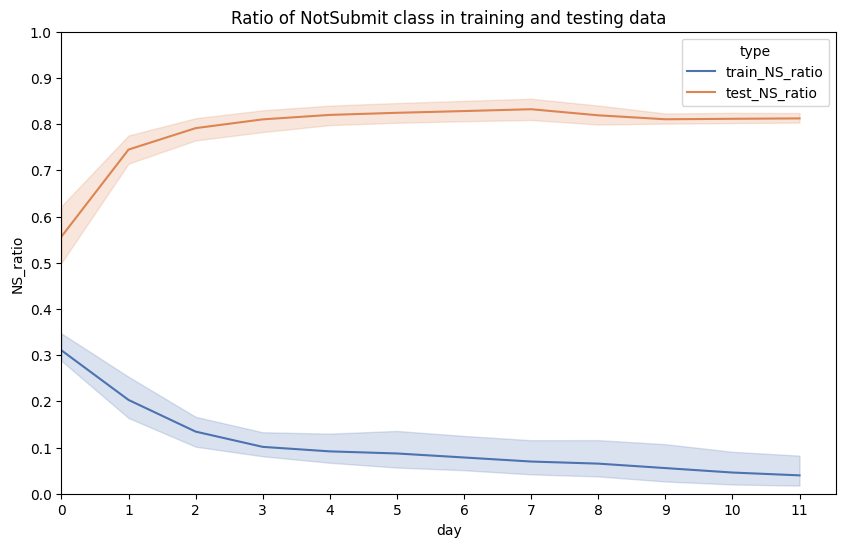

In [7]:
expClassNumbers.plot_class_counts()

## Daily Experiments

### Init classifiers for all experiments 

In [8]:
classifiers = [(SVC(kernel="rbf", gamma='auto', C=1, probability=True, class_weight="balanced"), "SVM-W-R"),
       (SVC(kernel="rbf", gamma='auto', C=1, probability=True), "SVM-R"),
       (LR.LogisticRegression(C=0.01, penalty='l2'), "LR"),
       (LR.LogisticRegression(C=0.01, penalty='l2', class_weight="balanced"), "LR-W"),
       (GaussianNB(), "NB"),
       (RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_split=2, min_samples_leaf=5), "RF"),
       (xgb.XGBClassifier(base_score=0.1, n_estimators=100, max_depth=3, reg_alpha=0.5, reg_lambda=1, learning_rate=0.01 ), "XGB"),
#                (NeverActiveStudentClassifier(), "Base[NotAccessed]"),
#                (DummyClassifier(strategy="constant", constant=1), "Base[NS]")
              ]

features = [
      'demog'
    , 'vle_statistics'
    , 'vle_statistics_beforestart'
    , 'vle_day_activity_type_flags'
    , 'vle_day_activity_type'
    , 'vle_day'
    , 'vle_day_flags'
    , 'reg_statistics'
  ]

### Training using the same course - Ouroboros

This is first part of the experiments, the selected classifiers were run for the selected modules in the 2014J presentation trained using the same presentation. The experiments were conducted for the cutoff and 11 days before.

In [9]:
kwargs = {'train_mode': TrainingType.SELFLEARNER,
          'max_days': max_days,
          'module_presentations':module_presentations_previous,
          'assessment_name':assessment,
          'classifiers':classifiers, 'features':features}
%time dailyExpSelflearner = lazy_load(EXP_OUROBOROS_DUMP_PATH, compute_experiment, kwargs=kwargs)

try loading
CPU times: user 67.1 ms, sys: 478 ms, total: 545 ms
Wall time: 923 ms


In [10]:
dailyExpSelflearner.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.638720,0.630354,0.260510,0.641648,0.545720,0.631947,0.551418
1,0.599145,0.592911,0.253093,0.605801,0.465811,0.599143,0.514056
2,0.556712,0.547060,0.242380,0.558783,0.338661,0.543313,0.423986
3,0.533589,0.521410,0.240251,0.529441,0.314599,0.511256,0.362746
4,0.501959,0.458382,0.236077,0.507174,0.313479,0.453045,0.329847
5,0.498976,0.450479,0.218374,0.476673,0.316193,0.433981,0.326633
6,0.499489,0.432932,0.205778,0.462940,0.289304,0.413755,0.309814
7,0.487289,0.432366,0.203348,0.485129,0.255157,0.408667,0.305312
8,0.518590,0.444882,0.202861,0.491810,0.227629,0.384367,0.316581
9,0.533876,0.424154,0.193324,0.523442,0.219686,0.354385,0.286110


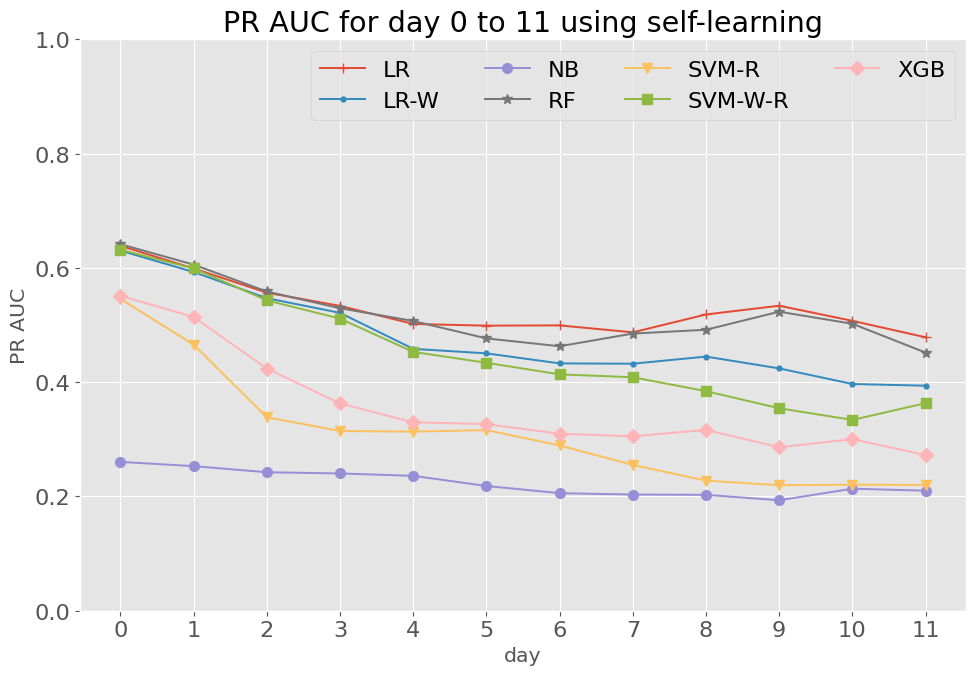

In [11]:
dailyExpSelflearner.plot_metric('pr_auc', metric_friendly_name='PR AUC',label_postfix='using self-learning', width=10, height=7)

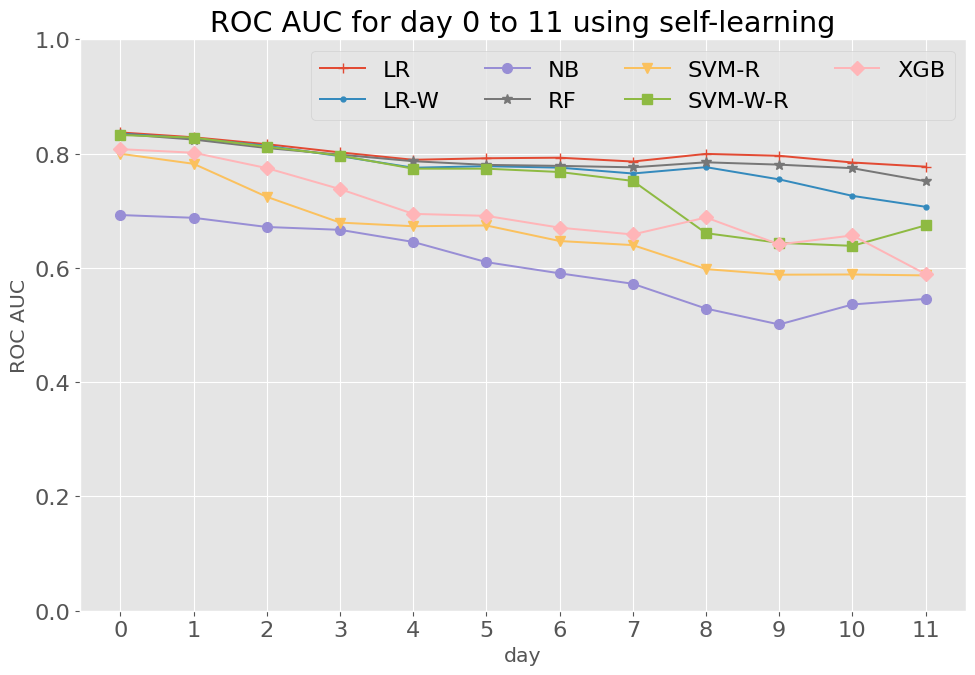

In [12]:
dailyExpSelflearner.plot_metric('auc', metric_friendly_name='ROC AUC',label_postfix='using self-learning', width=10, height=7)

###  Training using previous presentation


Same experiment as the previous one but the training is performed using the data from the previous presentation, i.e. 2013J.

In [13]:
kwargs = {'train_mode': TrainingType.PREVIOUS_PRES, 'max_days': max_days,
                  'module_presentations':module_presentations_previous,'assessment_name':assessment,
                  'classifiers':classifiers, 'features':features}
%time dailyExpPrevPres = lazy_load(EXP_PREVIOUS_PRES_DUMP_PATH, compute_experiment, kwargs=kwargs)

try loading
CPU times: user 70.9 ms, sys: 457 ms, total: 528 ms
Wall time: 798 ms


In [14]:
dailyExpPrevPres.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.638720,0.630354,0.260510,0.641030,0.545730,0.631926,0.551418
1,0.599145,0.592911,0.253093,0.604478,0.465809,0.599141,0.514056
2,0.556712,0.547060,0.242380,0.554823,0.338664,0.543312,0.423986
3,0.533589,0.521410,0.240251,0.530994,0.314602,0.511263,0.362746
4,0.501959,0.458382,0.236077,0.508147,0.313502,0.453045,0.329847
5,0.498976,0.450479,0.218374,0.486972,0.316237,0.433965,0.326633
6,0.499489,0.432932,0.205778,0.466191,0.289302,0.413755,0.309814
7,0.487289,0.432366,0.203348,0.471611,0.255158,0.408668,0.305312
8,0.518590,0.444882,0.202861,0.491347,0.236467,0.427659,0.316581
9,0.533876,0.424154,0.193324,0.512968,0.219686,0.389929,0.286110


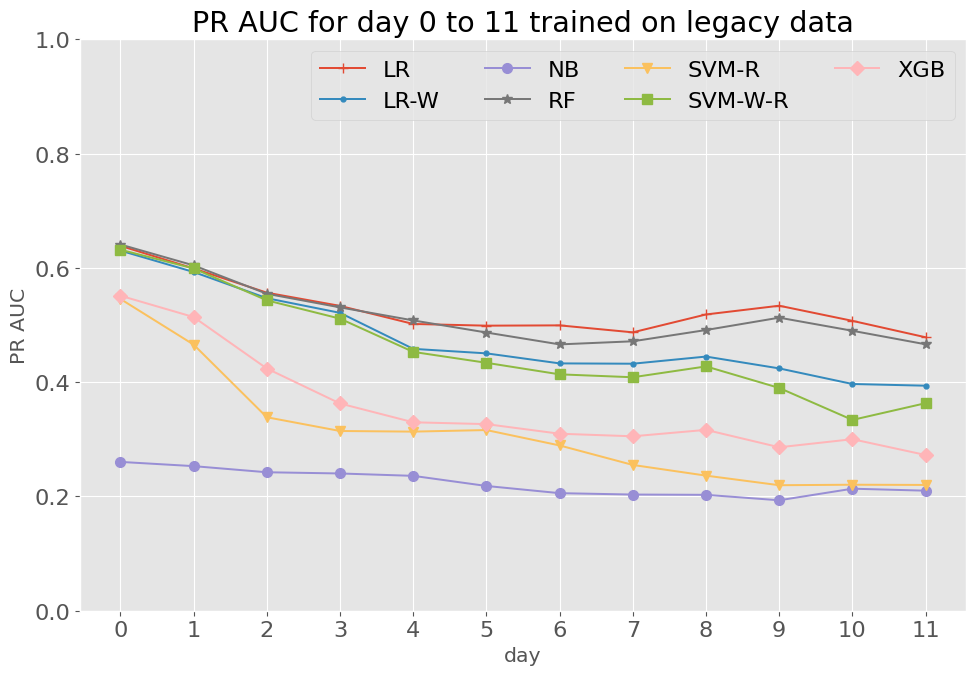

In [15]:
dailyExpPrevPres.plot_metric('pr_auc', metric_friendly_name='PR AUC', label_postfix='trained on legacy data', width=10, height=7)

### Top-K-Precision and Top-K-recall -- Ouroboros

Experiment with Top-K-Precision and Recall for $k \in \{ 5,10,15,25,50 \}.$

#### Top K Precision 

In [16]:
top_k_graph_width = 7
top_k_graph_height = 5

In [17]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 5)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.890798,0.873059,0.275581,0.891758,0.708058,0.882099,0.715525
1,0.827062,0.826415,0.257395,0.847609,0.559567,0.841591,0.676016
2,0.776891,0.760415,0.198429,0.780963,0.349096,0.772166,0.512808
3,0.747465,0.740708,0.229385,0.717616,0.310965,0.727473,0.428462
4,0.695725,0.645390,0.208576,0.711791,0.329650,0.601051,0.420774
5,0.689221,0.600853,0.232863,0.676677,0.350530,0.573608,0.407489
6,0.701540,0.561045,0.169021,0.602300,0.319710,0.489871,0.394555
7,0.686881,0.551410,0.196417,0.695358,0.231676,0.512305,0.374105
8,0.679574,0.521300,0.175384,0.651908,0.164460,0.455615,0.361694
9,0.705001,0.482286,0.132003,0.734976,0.138785,0.412458,0.319852


In [18]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 10)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.717573,0.706218,0.291307,0.727034,0.597076,0.719417,0.611304
1,0.682957,0.680954,0.276571,0.684810,0.512920,0.693615,0.602411
2,0.656491,0.655244,0.225003,0.632316,0.329088,0.653290,0.467812
3,0.623668,0.614399,0.238994,0.617007,0.302561,0.615373,0.373713
4,0.582064,0.540341,0.232511,0.588889,0.309729,0.551214,0.376106
5,0.581793,0.551592,0.209921,0.555097,0.309706,0.532882,0.357856
6,0.581817,0.522320,0.200962,0.563574,0.303207,0.490113,0.350171
7,0.597893,0.517272,0.200296,0.596292,0.244388,0.490651,0.366382
8,0.629650,0.523069,0.176878,0.615942,0.172395,0.439458,0.349519
9,0.638109,0.528134,0.152827,0.660965,0.153838,0.403119,0.328773


In [19]:
dailyExpSelflearner.get_metric_daily_df('top_k_prec', 25)

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.449616,0.447002,0.279386,0.447198,0.405851,0.448442,0.401420
1,0.437992,0.435566,0.265581,0.439757,0.396406,0.437813,0.407676
2,0.424582,0.427861,0.230761,0.425640,0.310638,0.429221,0.380377
3,0.418871,0.407768,0.236430,0.423252,0.275505,0.409003,0.328485
4,0.410274,0.395423,0.233047,0.405325,0.272235,0.391791,0.283876
5,0.416591,0.400083,0.201884,0.395214,0.286814,0.403762,0.297656
6,0.420438,0.401298,0.203882,0.410868,0.249643,0.390137,0.284437
7,0.422480,0.394963,0.201574,0.412719,0.245533,0.384549,0.299821
8,0.463875,0.424730,0.188718,0.441576,0.214271,0.337845,0.320768
9,0.468626,0.424775,0.180780,0.459174,0.187009,0.349438,0.308481


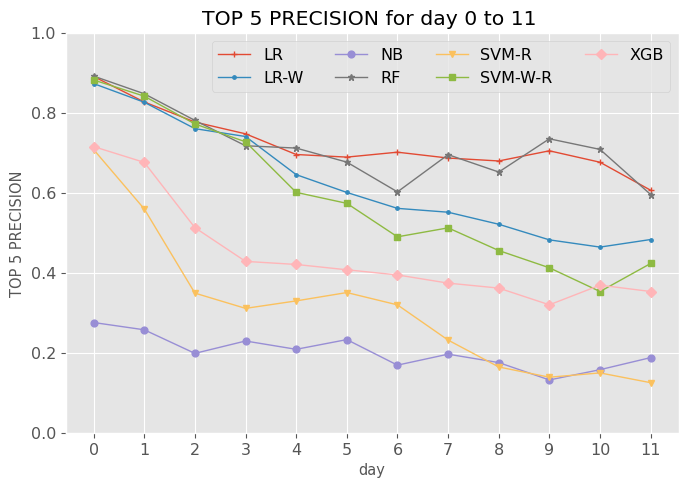

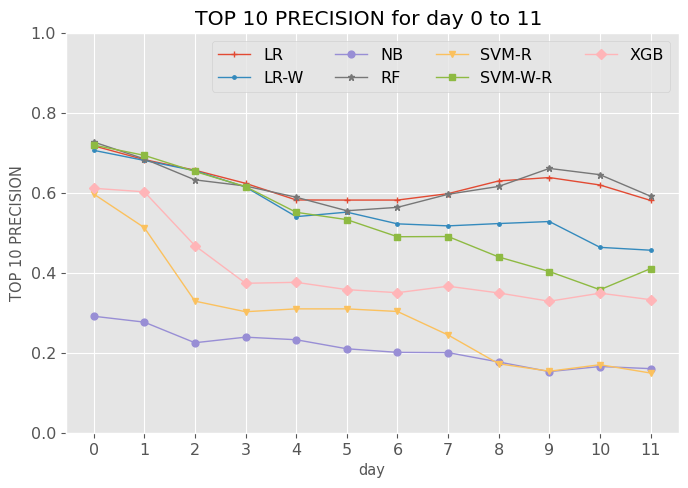

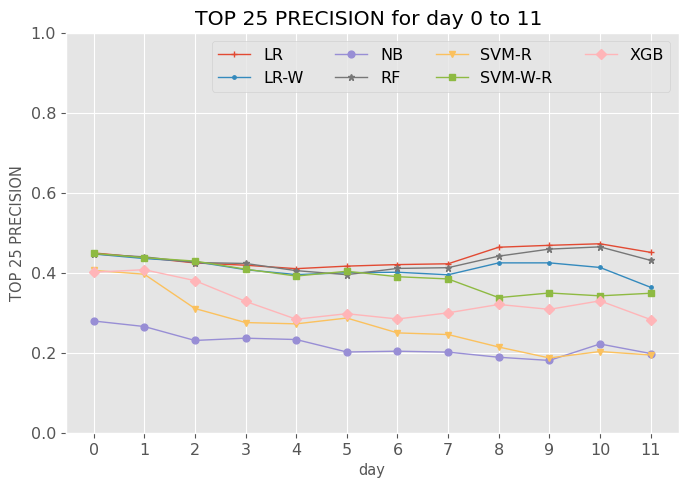

In [20]:
dailyExpSelflearner.plot_metric('top_k_prec', k=5, metric_friendly_name='TOP 5 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_prec', k=10, metric_friendly_name='TOP 10 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_prec', k=25, metric_friendly_name='TOP 25 PRECISION', width=top_k_graph_width, height=top_k_graph_height)

#### Top K Recall 

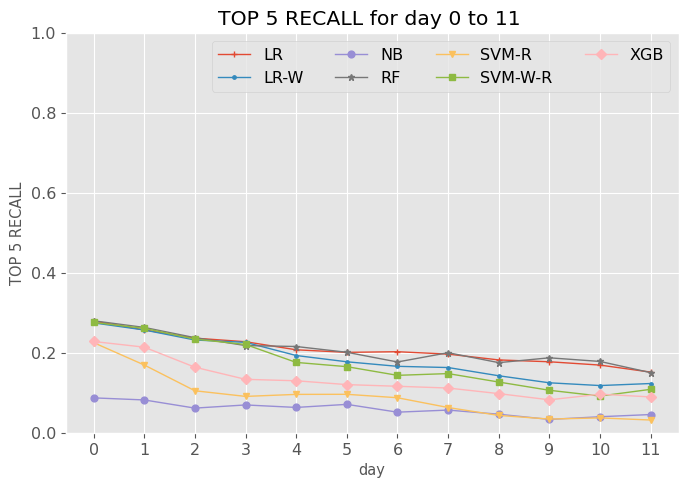

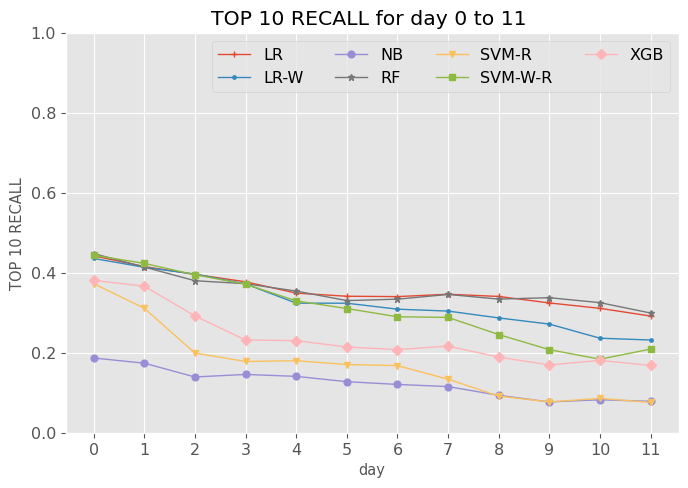

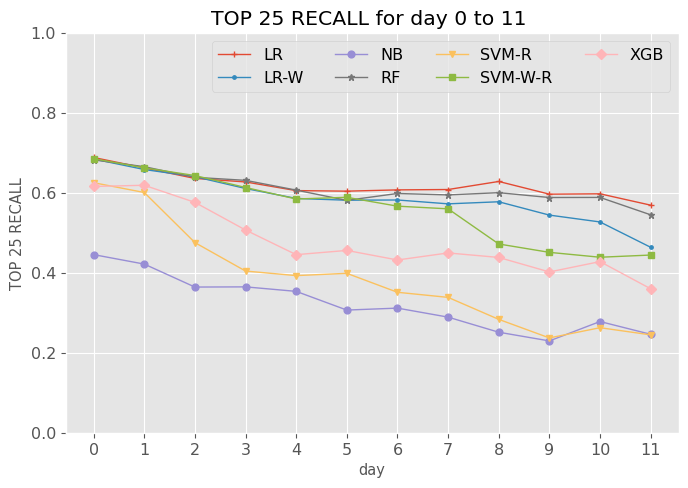

In [21]:
dailyExpSelflearner.plot_metric('top_k_rec', k=5, metric_friendly_name='TOP 5 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_rec', k=10, metric_friendly_name='TOP 10 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpSelflearner.plot_metric('top_k_rec', k=25, metric_friendly_name='TOP 25 RECALL', width=top_k_graph_width, height=top_k_graph_height)

### Top-K-Precision and Top-K-recall -- Previous presentation

The same experiment but training using the previous presentation.

#### Top K Precision 

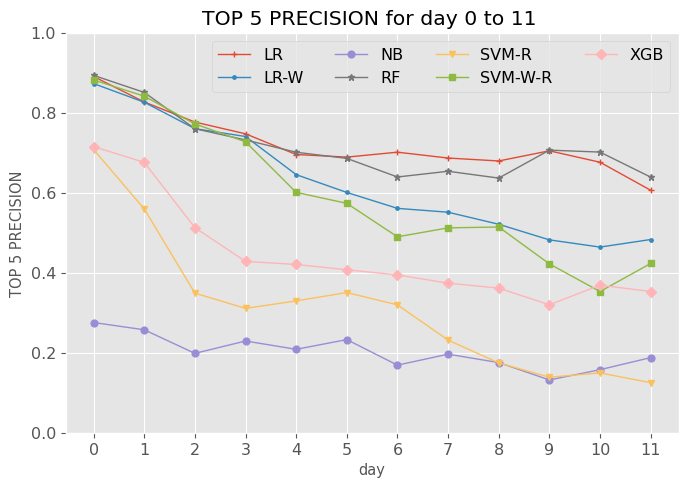

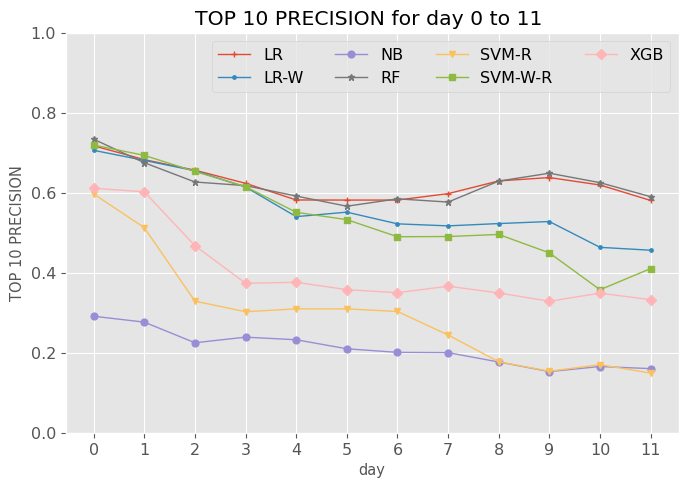

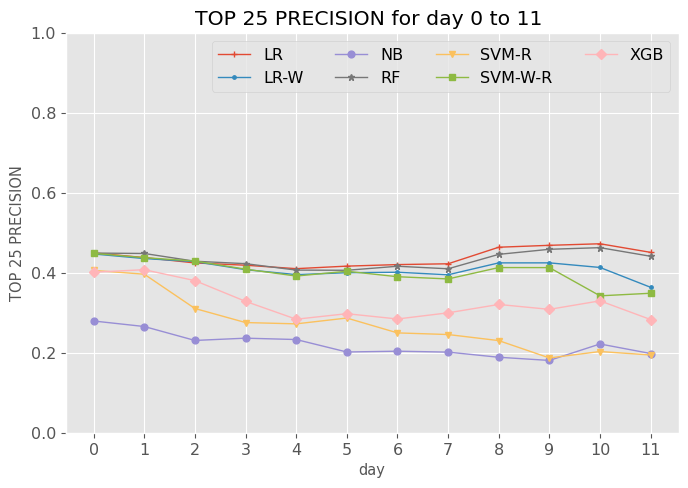

In [22]:
dailyExpPrevPres.plot_metric('top_k_prec', k=5, metric_friendly_name='TOP 5 PRECISION',  width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_prec', k=10, metric_friendly_name='TOP 10 PRECISION', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_prec', k=25, metric_friendly_name='TOP 25 PRECISION',  width=top_k_graph_width, height=top_k_graph_height)

#### Top K Recall 

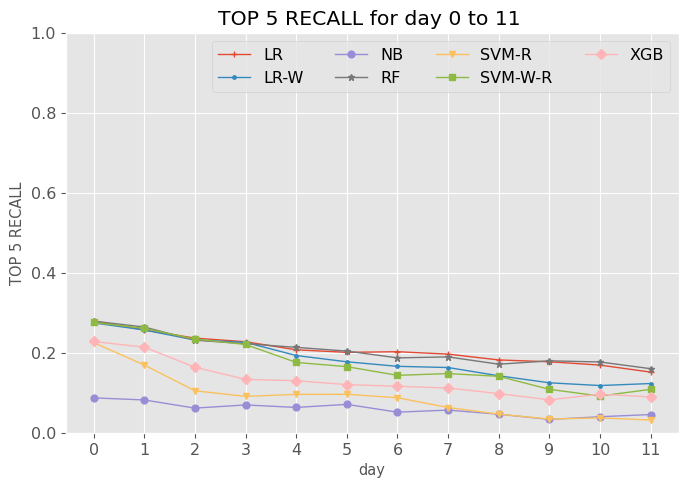

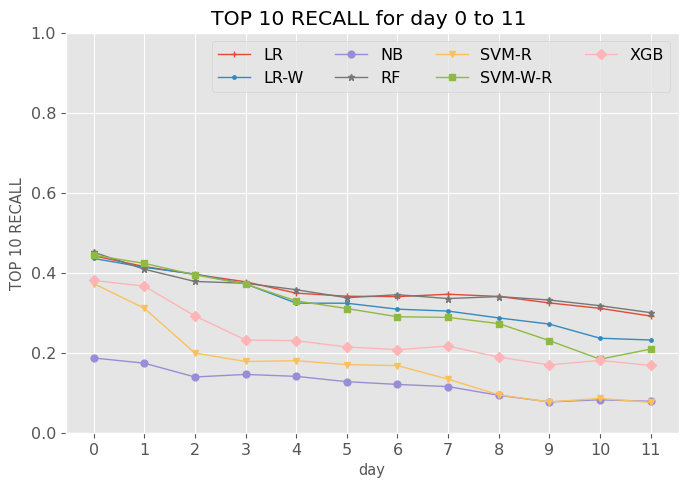

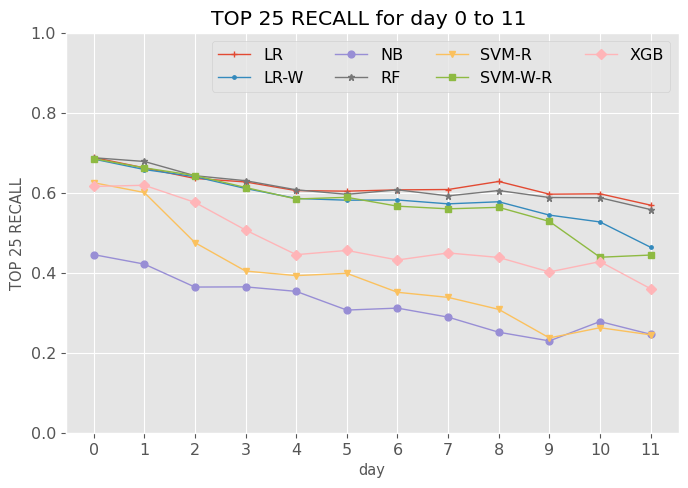

In [23]:
dailyExpPrevPres.plot_metric('top_k_rec', k=5, metric_friendly_name='TOP 5 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_rec', k=10, metric_friendly_name='TOP 10 RECALL', width=top_k_graph_width, height=top_k_graph_height)
dailyExpPrevPres.plot_metric('top_k_rec', k=25, metric_friendly_name='TOP 25 RECALL', width=top_k_graph_width, height=top_k_graph_height)

## Daily experiments with sampling 

This experiment is the same as the daily experiment using learning on the same presentation. Moreover, here the sampling methods are used to modify the distribution of the training data to deal with the imbalanced distribution.

In [24]:
from imblearn.under_sampling import TomekLinks 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

In [25]:
# If the sampling algorithm is changed and you want to re-run the experiment, it's important to force the rerun
# for the lazy loader
sampler = TomekLinks() 

kwargs = {'train_mode': TrainingType.SELFLEARNER,
          'max_days': max_days,
          'module_presentations': module_presentations,
          'assessment_name':assessment,
          'classifiers':classifiers, 
          'features':features,
          'sampler':sampler}
%time dailyExpSampling = lazy_load(EXP_OUROBOROS_SAMPLING_DUMP_PATH, compute_experiment, kwargs=kwargs)

try loading
CPU times: user 62.9 ms, sys: 470 ms, total: 533 ms
Wall time: 927 ms


### Results 

In [26]:
dailyExpSampling.get_metric_daily_df('pr_auc')

classifier,LR,LR-W,NB,RF,SVM-R,SVM-W-R,XGB
0,0.773795,0.774563,0.554130,0.777708,0.750409,0.779198,0.765853
1,0.614087,0.618889,0.387025,0.625210,0.414209,0.620153,0.576331
2,0.539832,0.535027,0.290650,0.549151,0.321803,0.547465,0.418607
3,0.484920,0.461042,0.266663,0.514068,0.267980,0.478614,0.374788
4,0.486392,0.440539,0.240311,0.495153,0.252747,0.467145,0.359332
5,0.464914,0.428756,0.219692,0.472223,0.240853,0.436790,0.310775
6,0.455717,0.411028,0.206099,0.447975,0.217300,0.426464,0.289286
7,0.450021,0.382155,0.185611,0.433190,0.211095,0.409932,0.292833
8,0.468553,0.381897,0.203484,0.456371,0.208080,0.419791,0.307548
9,0.501827,0.397380,0.204751,0.498681,0.211446,0.416853,0.273601


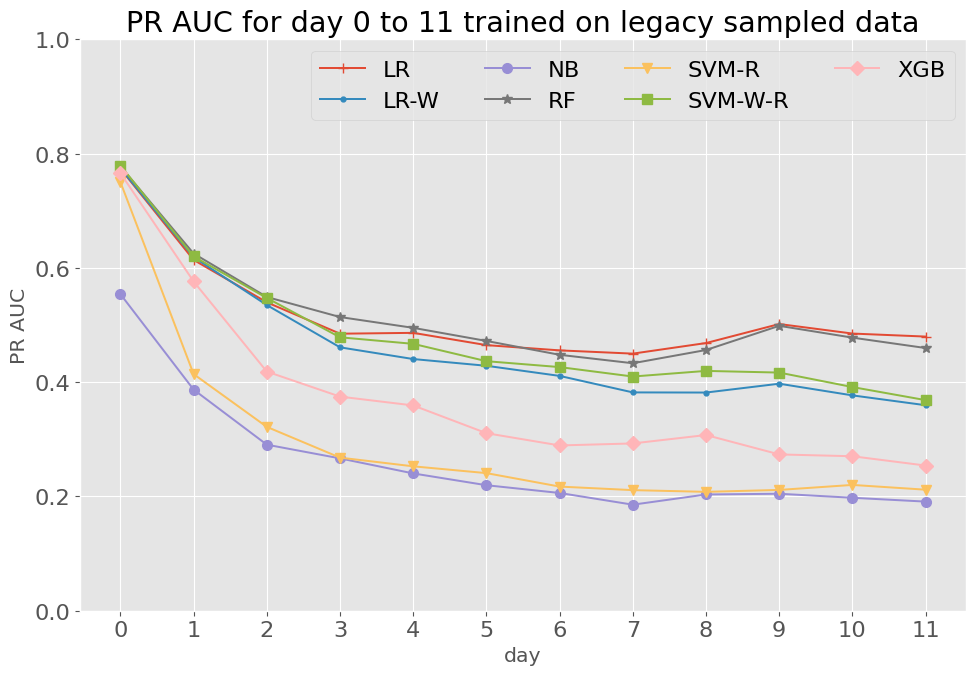

In [27]:
dailyExpSampling.plot_metric('pr_auc', metric_friendly_name='PR AUC', label_postfix='trained on legacy sampled data', width=10, height=7)

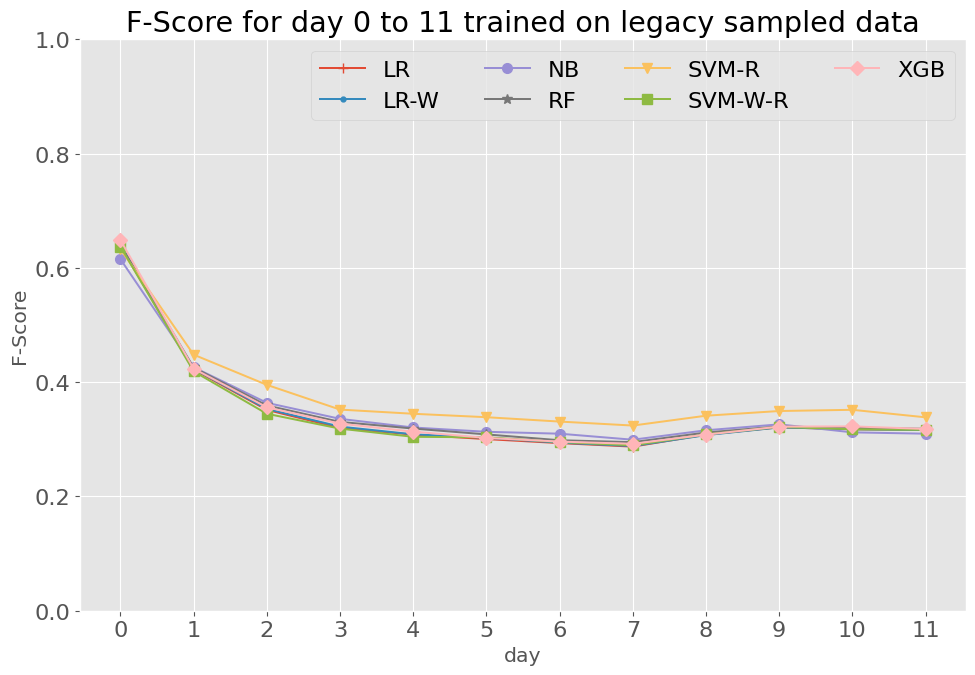

In [28]:
dailyExpSampling.plot_metric('fscore', metric_friendly_name='F-Score', label_postfix='trained on legacy sampled data', width=10, height=7)

## Feature importance

Top N features for the selected algorithms and in the selected days, for the paper days 0,3 and 7 were presented.

In [29]:
num_of_top_features = 5
classifier  = 'XGB'
selected_days = [0,3,7]

df = dailyExpSelflearner.get_features_df()
df = df[df.day.isin(selected_days)]

In [30]:
g  = df[['code_module','day','feature_name',classifier]].set_index(['code_module','day'])
g = g.groupby(level=[0,1], group_keys=False)
g = g.apply(lambda x: x.sort_values(classifier, ascending=False))
g["rank"] = g.groupby(level=[0,1])[classifier].rank(method="first",ascending=False).apply(lambda x:int(x))
g = g[['feature_name','rank']]
g.groupby(level=[0,1]).head(num_of_top_features).reset_index().set_index(['code_module','rank','day']).unstack()

feature_name                                                                      
day                                      0                                3                                    7
code_module rank                                                                                                
BBB         1         count_days_fromstart            sum_click_beforestart  median_clicks_beforestart_peractive
            2                   last_login                      first_login                          sum_click_2
            3       count_days_fromvleopen           max_clicks_beforestart                         sum_click_14
            4        sum_click_fromvleopen     min_material_count_fromstart                 sum_click_14_forumng
            5         sum_click_28_subpage                     sum_click_13                sum_click_14_homepage
DDD         1     sum_material_fromvleopen                     sum_click_18                  is_click_6_homepage
            2        sum_click_beforestart                 sum_click_29_url                 sum_click_14_subpage
            3          sum_click_14_ouwiki          region=Yorkshire Region                 sum_click_11_subpage
            4         sum_click_32_subpage               sum_click_9_ouwiki                  sum_click_1_subpage
...                                    ...                              ...                                  ...
EEE         2       count_days_fromvleopen  median_material_count_fromstart                      sum_click_5_url
            3                   last_login                  is_click_11_url                sum_click_28_homepage
            4     sum_material_fromvleopen                  sum_click_4_url                 sum_click_4_homepage
            5         sum_click_3_homepage             sum_click_11_forumng                sum_click_23_resource
FFF         1       sum_material_fromstart              sum_click_fromstart             sum_material_fromvleopen
            2       max_material_fromstart           sum_material_fromstart                sum_click_fromvleopen
            3     sum_material_fromvleopen           max_material_fromstart               sum_material_fromstart
            4                   last_login                       last_login               sum_click_27_oucontent
            5           is_click_5_subpage             count_days_fromstart                     sum_click_9_quiz

[20 rows x 3 columns]